In [ ]:
import os
import random
import numpy as np
from tqdm import tqdm
import pandas as pd
# Enable deterministic TensorFlow operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'
import tensorflow as tf

def set_seed(seed):
    """Set random seeds for reproducibility."""
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    print(f"Random seed set to {seed}")

def load_ratings_data(file_path, user_col='userId', item_col='itemId', rating_col='rating'):
    """Load ratings data from CSV with explicit dtypes."""
    ratings_df = pd.read_csv(
        file_path,
        dtype={user_col: int, item_col: int, rating_col: float}
    )
    print(
        f"Loaded {len(ratings_df)} ratings, "
        f"{ratings_df[user_col].nunique()} users, "
        f"{ratings_df[item_col].nunique()} items"
    )
    return ratings_df

def create_rating_matrix(
    ratings_df, user_col='userId', item_col='itemId', rating_col='rating'
):
    """
    Create user-item matrix and mask.

    Returns:
        rating_matrix (np.ndarray): NaN for missing entries.
        mask_matrix (np.ndarray): True where ratings exist.
        user_mapping (dict), item_mapping (dict).
    """
    unique_users = sorted(ratings_df[user_col].unique())
    unique_items = sorted(ratings_df[item_col].unique())
    user_mapping = {u: i for i, u in enumerate(unique_users)}
    item_mapping = {o: j for j, o in enumerate(unique_items)}
    n_users, n_items = len(unique_users), len(unique_items)

    rating_matrix = np.full((n_users, n_items), np.nan, dtype=np.float32)
    mask_matrix   = np.zeros((n_users, n_items), dtype=bool)

    users = ratings_df[user_col].map(user_mapping).to_numpy()
    items = ratings_df[item_col].map(item_mapping).to_numpy()
    vals  = ratings_df[rating_col].to_numpy()
    rating_matrix[users, items] = vals
    mask_matrix[users, items]   = True

    print(f"Created rating matrix of shape {rating_matrix.shape}")
    return rating_matrix, mask_matrix, user_mapping, item_mapping

In [ ]:
import numpy as np
import pandas as pd
import logging
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

logging.basicConfig(level=logging.INFO)
def load_user_features(user_file, user_mapping):
    """
    Returns:
      X_user (np.ndarray): Processed user features (n_users × n_features).
      feature_names (List[str]): Names of output feature columns.
    """
    # Read with explicit dtypes and NA parsing
    df = pd.read_csv(
        user_file, sep='|',
        names=['userId','age','gender','occupation','zip_code'],
        encoding='latin-1',
        dtype={'userId':int,'age':float,'gender':'category','occupation':'category','zip_code':str},
        na_values=['','NA']
    )
    logging.info("Loaded %d user rows", df.shape[0])

    # Align and reindex safely
    df = df.set_index('userId').reindex(list(user_mapping.keys()))

    # Pipeline for numerical and categorical features
    num_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale', MinMaxScaler())
    ])
    cat_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer([
        ('age', num_pipeline, ['age']),
        ('cat', cat_pipeline, ['gender','occupation'])
    ])

    # Transform to dense NumPy array and compute features
    X_user = preprocessor.fit_transform(df).astype(np.float32)        # Ensures dense output for variance[1]
    feature_names = preprocessor.get_feature_names_out()

    # Remove constant columns
    variances = X_user.var(axis=0)                                     # Valid on dense arrays[2]
    keep = variances > 0
    X_user = X_user[:, keep]
    feature_names = feature_names[keep]

    return X_user, feature_names
def load_item_features(item_file, item_mapping):
    """
    Returns:
      X_item (np.ndarray): Processed item features (n_items × n_genres).
      genre_names (List[str]): Genre column names.
    """
    cols = [
        'itemId','title','release_date','video_release_date','IMDb_URL',
        'unknown','Action','Adventure','Animation',"Children's",'Comedy',
        'Crime','Documentary','Drama','Fantasy','Film-Noir','Horror',
        'Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'
    ]
    df = pd.read_csv(
        item_file, sep='|', names=cols, encoding='latin-1',
        dtype={'itemId':int}, usecols=['itemId']+cols[5:], na_values=['']
    )
    logging.info("Loaded %d item rows", df.shape[0])

    # Align and fill missing genre flags with 0
    genre_cols = cols[5:]
    df = df.set_index('itemId').reindex(list(item_mapping.keys()), fill_value=0)

    X_item = df[genre_cols].to_numpy(dtype=np.float32)
    logging.info("Final item features: %d items × %d genres", X_item.shape[0], X_item.shape[1])
    return X_item, genre_cols

def compute_bias_terms(rating_matrix, mask_matrix):
    """
    Computes global mean (μ), user biases (b_u), and item biases (b_i).
    """
    μ = np.nanmean(rating_matrix)
    b_u = np.nanmean(rating_matrix - μ, axis=1)
    b_i = np.nanmean(rating_matrix - μ, axis=0)
    return μ, b_u, b_i


In [ ]:
import logging
from sklearn.model_selection import train_test_split

def split_users_train_test(rating_matrix, train_ratio=0.7, random_state=42):
    """
    Splits users into training and testing sets and returns both indices and masks.
    Returns:
        train_indices (np.ndarray), test_indices (np.ndarray),
        train_user_mask (np.ndarray), test_user_mask (np.ndarray)
    """
    n_users = rating_matrix.shape[0]
    user_indices = np.arange(n_users)

    train_indices, test_indices = train_test_split(
        user_indices,
        train_size=train_ratio,
        random_state=random_state,
        shuffle=True
    )
    # Create boolean masks for users
    train_user_mask = np.zeros(n_users, dtype=bool)
    test_user_mask  = np.zeros(n_users, dtype=bool)
    train_user_mask[train_indices] = True
    test_user_mask[test_indices]   = True

    logging.info(
        "Split users: %d train, %d test",
        train_indices.size, test_indices.size
    )
    return train_indices, test_indices, train_user_mask, test_user_mask

def create_train_test_matrices(rating_matrix, mask_matrix, train_indices, test_indices):
    """
    Splits rating matrix and mask into per-user train/test subsets.
    Returns:
        train_matrix, test_matrix, train_mask_matrix, test_mask_matrix
    """
    train_matrix = rating_matrix[train_indices]
    test_matrix  = rating_matrix[test_indices]

    train_mask_matrix = mask_matrix[train_indices]
    test_mask_matrix  = mask_matrix[test_indices]

    return (
        train_matrix,
        test_matrix,
        train_mask_matrix,
        test_mask_matrix
    )
from sklearn.model_selection import KFold

def get_user_folds(n_users, n_splits=5, random_state=42):
    """
    Generates train/test user index splits using k-fold CV.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    for train_idx, test_idx in kf.split(np.arange(n_users)):
        yield train_idx, test_idx


In [ ]:
import numpy as np
from typing import Optional

def prepare_matrix_as_image_with_features(
    rating_matrix: np.ndarray,
    train_mask_matrix: Optional[np.ndarray] = None,
    user_features_norm: Optional[np.ndarray] = None,
    item_features_norm: Optional[np.ndarray] = None,
    normalize: bool = True
) -> tuple:

    # 1. Observation mask and zero-fill missing ratings
    mask = ~np.isnan(rating_matrix)
    ratings = np.nan_to_num(rating_matrix, nan=0.0).astype(np.float32)
    # 2. Fixed-scale normalization
    max_rating = 5.0
    normalized = ratings / max_rating if normalize else ratings

    # 3. Compute mean over training ratings if mask provided, else all observed
    valid_mask = train_mask_matrix if train_mask_matrix is not None else mask
    total = float(np.sum(valid_mask))
    mean_rating = float(np.sum(normalized * valid_mask) / (total + 1e-8))

    # 4. Fill missing entries with computed mean
    filled = np.where(mask, normalized, mean_rating)

    # 5. Assemble base channels: filled ratings and observation mask
    n_users, n_items = rating_matrix.shape
    channels = [filled[..., None], mask.astype(np.float32)[..., None]]

    # 6. Append user feature channels (broadcast across items)
    if user_features_norm is not None:
        uf = np.repeat(user_features_norm[:, None, :], n_items, axis=1)
        channels.append(uf)

    # 7. Append item feature channels (broadcast across users)
    if item_features_norm is not None:
        itf = np.repeat(item_features_norm[None, :, :], n_users, axis=0)
        channels.append(itf)

    # 8. Concatenate all channels
    stacked = np.concatenate(channels, axis=-1)

    # 9. Reflective padding to square and reshape
    side_len = int(np.ceil(np.sqrt(n_items)))
    pad_total = side_len * side_len - n_items
    padded = np.pad(
        stacked,
        pad_width=((0, 0), (0, pad_total), (0, 0)),
        mode='reflect'
    )
    result_data = padded.reshape(n_users, side_len, side_len, -1)

    return result_data, max_rating, mean_rating

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D,
    Dropout, BatchNormalization, Cropping2D, Activation
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import SpatialDropout2D


def create_cnn_autoencoder(
    input_shape,
    filters=32,
    kernel_size=3,
    dropout_rate=0.5,
    lr_factor=1e-4,
    use_bn=True
):
    """
    Create a CNN autoencoder with L2 regularization and optional batch normalization.
    """
    height, width, channels = input_shape
    inputs = Input(shape=input_shape)
    strong_decay = lr_factor * 2.0
    # Encoder
    x = Conv2D(
        filters, kernel_size,
        padding='same', kernel_regularizer=l2(strong_decay)
    )(inputs)
    if use_bn:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(
        filters * 2, kernel_size,
        padding='same', kernel_regularizer=l2(strong_decay)
    )(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    higher_dropout = 0.5
    x = SpatialDropout2D(higher_dropout)(x)

    # Decoder
    x = Conv2D(
        filters * 2, kernel_size,
        padding='same', kernel_regularizer=l2(strong_decay)
    )(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(
        filters, kernel_size,
        padding='same', kernel_regularizer=l2(strong_decay)
    )(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)

    # Output layer
    x = Conv2D(
        1, kernel_size, activation='sigmoid',
        padding='same', kernel_regularizer=l2(lr_factor)
    )(x)

    # Crop to match input dimensions if needed
    final_h, final_w = tf.keras.backend.int_shape(x)[1:3]
    crop_h = final_h - height
    crop_w = final_w - width
    if crop_h > 0 or crop_w > 0:
        top = crop_h // 2
        bottom = crop_h - top
        left = crop_w // 2
        right = crop_w - left
        x = Cropping2D(((top, bottom), (left, right)))(x)

    return Model(inputs, x)

def create_masked_loss(delta=1.0):
    """
    Create a masked Huber loss that ignores unobserved entries.
    """
    def masked_huber(y_true, y_pred):
        mask = y_true[..., 1:2]                      # Mask channel [3]
        true_vals = y_true[..., 0:1]                # Ratings channel
        error = true_vals - y_pred
        abs_err = tf.abs(error)
        quadratic = tf.minimum(abs_err, delta)
        linear = abs_err - quadratic
        huber = 0.5 * tf.square(quadratic) + delta * linear
        masked = mask * huber
        return tf.reduce_sum(masked) / (tf.reduce_sum(mask) + 1e-10)
    return masked_huber


In [ ]:
import numpy as np
import logging

def adaptive_min_overlap(
    user_ratings: np.ndarray,
    base_overlap: int = 5,
    min_floor: int = 3,
    sparse_frac: float = 0.1,
    lambda_shrink: float = 10.0,
    global_avg_count: float = None
) -> int:
    """
    Adapt minimum overlap based on user's rating density and apply shrinkage.

    Args:
        user_ratings (np.ndarray): 1D array with np.nan for missing entries.
        base_overlap (int): Default minimum co-rated items.
        min_floor (int): Lower bound for overlap.
        sparse_frac (float): Fraction of global user counts to treat as sparse.
        lambda_shrink (float): Shrinkage factor for similarity weighting.
        global_avg_count (float): Average number of ratings per user; if None, compute.

    Returns:
        int: Adapted minimum overlap for this user.
    """
    # Compute observed count using mask
    observed_count = int(np.sum(~np.isnan(user_ratings)))

    # Compute global average count if not provided
    if global_avg_count is None:
        # Placeholder: should be computed once for all users externally
        global_avg_count = observed_count

    # Determine sparse threshold dynamically
    sparse_threshold = max(min_floor, int(global_avg_count * sparse_frac))

    # Base adapted overlap
    if observed_count < sparse_threshold:
        # Apply dynamic floor and shrinkage
        overlap = max(min_floor, base_overlap // 2)
        # Optionally adjust by shrinkage: reduce further if very sparse
        overlap = int((overlap * observed_count) / (observed_count + lambda_shrink))
    else:
        overlap = base_overlap

    logging.debug(
        "User ratings=%d, sparse_threshold=%d, adaptive_overlap=%d",
        observed_count, sparse_threshold, overlap
    )

    return overlap


In [ ]:
import logging

def apply_significance_weighting(
    similarity: float,
    overlap_count: int,
    min_overlap: int = 5,
    full_confidence: int = 50,
    shrinkage: float = 10.0
) -> float:
    """
    Apply shrinkage-based significance weighting for user similarity.

    Args:
      similarity: Raw similarity score (e.g., Pearson).
      overlap_count: Number of co-rated items.
      min_overlap: Minimum co-ratings required to consider similarity.
      full_confidence: Overlap count beyond which similarity is trusted fully.
      shrinkage: Shrinkage parameter λ to down-weight small overlaps.
    """
    # 1. Require baseline overlap
    if overlap_count < min_overlap:
        logging.debug("Overlap %d < min_overlap %d → weight=0", overlap_count, min_overlap)
        return 0.0

    # 2. Full confidence region
    if overlap_count >= full_confidence:
        logging.debug("Overlap %d ≥ full_confidence %d → weight=sim", overlap_count, full_confidence)
        return similarity

    # 3. Shrinkage formula
    # sim_shrunk = (n_common * sim) / (n_common + λ)
    sim_shrunk = (overlap_count * similarity) / (overlap_count + shrinkage)
    logging.debug(
        "Overlap %d → sim_shrunk=(%d×%.4f)/(%.4f+%.4f)=%.4f",
        overlap_count, overlap_count, similarity, overlap_count, shrinkage, sim_shrunk
    )
    return sim_shrunk


In [ ]:
import numpy as np

def enhanced_fallback_prediction(
    rating_matrix: np.ndarray,
    mask_matrix: np.ndarray,
    mu: float,
    user_bias: np.ndarray,
    item_bias: np.ndarray,
    test_user_idx: int,
    user_features: np.ndarray = None
) -> np.ndarray:
    """
    Bias-aware multi-tier fallback:
      1. If CF yields no neighbors, predict µ + bᵤ + bᵢ.
      2. Otherwise, use baseline residuals adjusted by user/input features.
    """
    # 1. Extract user ratings and mask missing entries
    user_ratings = rating_matrix[test_user_idx]
    observed = ~np.isnan(user_ratings)

    # 2. Baseline prediction: global mean plus biases
    baseline = mu + user_bias[test_user_idx] + item_bias

    # 3. If user has any ratings, adjust fallback by user-specific average residual
    if np.any(observed):
        residuals = user_ratings[observed] - (mu + user_bias[test_user_idx] + item_bias[observed])
        avg_resid = np.mean(residuals)
        fallback = baseline + avg_resid
    else:
        fallback = baseline

    # 4. Clip to valid rating range [1, max_rating]
    return np.clip(fallback, 1.0, mu*2)


In [ ]:
import numpy as np

def find_similar_users(
    rating_matrix,
    train_mask,
    train_indices,
    test_user_idx,
    mu,
    b_u,
    b_i,
    top_n=30,
    base_overlap=5,
    lambda_shrink=10.0,
    verbose=False
):
    """Find top-N similar users with bias-centering and shrinkage weighting."""
    # 1. Masks and adaptive overlap
    test_mask = train_mask[test_user_idx]
    adaptive_overlap = adaptive_min_overlap(rating_matrix[test_user_idx], base_overlap)
    if verbose:
        count = np.sum(test_mask)
        print(f"User {test_user_idx}: {count} observed, min_overlap={adaptive_overlap}")

    candidates = []

    # 2. Iterate over training users
    for train_idx in train_indices:
        # Common-mask for co-rated and training entries
        common = test_mask & train_mask[train_idx]
        n_common = int(np.sum(common))
        if n_common < adaptive_overlap:
            continue

        # Extract common ratings
        items_common = np.where(common)[0]
        test_vals  = rating_matrix[test_user_idx, items_common]
        train_vals = rating_matrix[train_idx,       items_common]

        # Center residuals by biases
        res_test  = test_vals  - (mu + b_u[test_user_idx] + b_i[items_common])
        res_train = train_vals - (mu + b_u[train_idx]       + b_i[items_common])

        # Compute Pearson denominator
        denom = np.linalg.norm(res_test) * np.linalg.norm(res_train)
        if denom == 0:
            continue

        # Raw similarity and shrinkage weighting
        sim = np.dot(res_test, res_train) / denom
        sim_shrunk = (n_common * sim) / (n_common + lambda_shrink)
        candidates.append((train_idx, sim_shrunk))

    # 3. Sort candidates and select top-n
    candidates.sort(key=lambda x: x[1], reverse=True)
    selected = candidates[:top_n]

    # Unzip into separate lists
    similar_user_indices = [u for u, s in selected]
    top_similarities     = np.array([s for u, s in selected], dtype=np.float32)

    return similar_user_indices, top_similarities

def predict_ratings_cf(
    rating_matrix: np.ndarray,
    train_mask: np.ndarray,
    similar_user_indices: list,
    similarities: np.ndarray,
    test_user_idx: int,
    mu: float,
    b_u: np.ndarray,
    b_i: np.ndarray,
    lambda_shrink: float = 10.0
) -> np.ndarray:
    """
    Generate CF predictions using bias-centered residuals and shrinkage-weighted neighbors.

    Args:
      rating_matrix: 2D array with NaN for missing entries.
      train_mask: Boolean mask shaping which entries are used for training.
      similar_user_indices: List of neighbor user indices.
      similarities: Array of raw similarity scores for neighbors.
      test_user_idx: Index of the target user.
      mu: Global mean rating.
      b_u: Array of user bias terms.
      b_i: Array of item bias terms.
      lambda_shrink: Shrinkage parameter λ to attenuate noise.

    Returns:
      Array of predicted ratings clipped to [1.0, 5.0].
    """

    # 1. Compute shrinkage-weighted neighbor weights
    n_neighbors = len(similar_user_indices)
    # Shrink similarities: (n_common * sim) / (n_common + λ)
    weights = (similarities * n_neighbors) / (n_neighbors + lambda_shrink)
    # Normalize weights to sum to 1
    weights = weights / (np.sum(weights) + 1e-10)

    # 2. Aggregate neighbor residuals
    n_items = rating_matrix.shape[1]
    pred_deviations = np.zeros(n_items, dtype=np.float32)
    for w, nbr_idx in zip(weights, similar_user_indices):
        # Mask neighbor’s valid ratings
        nbr_mask = train_mask[nbr_idx]
        nbr_vals = np.where(nbr_mask, rating_matrix[nbr_idx], np.nan)

        # Compute residuals: rₙᵢ – (μ + bₙ + bᵢ)
        resid = nbr_vals - (mu + b_u[nbr_idx] + b_i)
        resid = np.nan_to_num(resid, nan=0.0)

        # Weighted sum of residuals
        pred_deviations += w * resid

    # 3. Reconstruct final predictions: baseline + residuals
    baseline = mu + b_u[test_user_idx] + b_i
    predictions = baseline + pred_deviations

    # 4. Clip predictions to valid rating range
    return np.clip(predictions, 1.0, 5.0)



In [ ]:
import os
from datetime import datetime
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
)

def setup_callbacks(
    patience=10,
    min_delta=0.0001,
    model_path='best_model.weights.h5',
    tb_log_dir='logs'):
  """Setup callbacks: early stopping, checkpoint, LR reduction, TensorBoard."""
  # Ensure checkpoint directory exists
  os.makedirs(os.path.dirname(model_path) or '.', exist_ok=True)

    # Early stopping
  early_stopping = EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience = 8,
        verbose=1,
        restore_best_weights=True,
        min_delta = 1e-4
    )

    # Model checkpoint with correct weights-only extension
  model_checkpoint = ModelCheckpoint(
        filepath=model_path,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )

    # Reduce LR on plateau
  reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        mode='min',
        factor=0.5,
        patience=4,
        verbose=1,
        min_delta=1e-4,
        cooldown=2,
        min_lr=1e-6
    )

    # TensorBoard logging
  log_dir = os.path.join(tb_log_dir, datetime.now().strftime('%Y%m%d-%H%M%S'))
  tensorboard = TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,
        write_graph=True
    )

  return [early_stopping, model_checkpoint, reduce_lr, tensorboard]

from tensorflow.keras.optimizers import Adam
import numpy as np

def train_model(
    model,
    train_data,
    val_data,
    batch_size=32,
    epochs=100,
    lr=1e-3,
    callbacks=None
):
    """
    Train CNN autoencoder with masked Huber loss and fold-based validation.

    Args:
      model: Keras autoencoder model.
      train_data: Training image tensor.
      val_data: Validation image tensor.
      batch_size: Mini-batch size.
      epochs: Maximum epochs.
      lr: Initial learning rate.
      callbacks: List of callbacks (early stop, checkpoint, TensorBoard).

    Returns:
      history: Training history object.
    """
    # 1. Compile with masked Huber loss and Adam optimizer
    if callbacks is None:
        callbacks = setup_callbacks()
    masked_huber = create_masked_loss(delta=1.0)
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=masked_huber, metrics=[masked_huber])

    # 2. Fit model
    history = model.fit(
        train_data, train_data,
        validation_data=(val_data, val_data),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    return history



In [ ]:
import numpy as np

def prepare_single_user_data_with_features(
    user_vector: np.ndarray,
    max_rating: float,
    mean_rating: float,
    n_items: int,
    height: int,
    width: int,
    user_feat_norm: np.ndarray = None,
    item_feats_norm: np.ndarray = None
) -> np.ndarray:
    """
    Prepare a single user's rating vector and features as a square image tensor
    for CNN input. Handles NaN-based missing values, fixed-scale normalization,
    training-only mean filling, and reflective padding.

    Args:
        user_vector (np.ndarray): 1D array of user's ratings with np.nan for missing.
        max_rating (float): Fixed maximum rating scale (e.g., 5.0).
        mean_rating (float): Mean of normalized training ratings to impute missing.
        n_items (int): Number of total items.
        height (int): Height of output image grid.
        width (int): Width of output image grid.
        user_feat_norm (np.ndarray, optional): Pre-normalized user feature vector.
        item_feats_norm (np.ndarray, optional): Pre-normalized item feature matrix
            of shape (n_items, n_item_features).

    Returns:
        np.ndarray: 4D tensor of shape (1, height, width, n_channels) ready for CNN.
    """
    # 1. Create boolean mask for observed ratings
    mask = ~np.isnan(user_vector)  # True for observed, False for missing [1]

    # 2. Zero-fill NaNs and normalize ratings by fixed max_rating
    ratings = np.nan_to_num(user_vector, nan=0.0).astype(np.float32)  # Replace NaN with 0 [1]
    normalized = ratings / max_rating                                   # Scale to [0,1] [2]

    # 3. Fill missing entries using the mean_rating from training data
    filled = np.where(mask, normalized, mean_rating)                    # Avoid test leakage [3]

    # 4. Assemble base channels: filled ratings and observation mask
    channels = [
        filled[..., None],
        mask.astype(np.float32)[..., None]
    ]

    # 5. Append user feature channel if provided (broadcast across items)
    if user_feat_norm is not None:
        uf = np.repeat(user_feat_norm[None, :], n_items, axis=0)
        channels.append(uf.astype(np.float32))                         # Consistent dtype [4]

    # 6. Append item feature channels if provided
    if item_feats_norm is not None:
        channels.append(item_feats_norm.astype(np.float32))            # (n_items, n_item_features) [4]

    # 7. Concatenate all channels into a 2D representation
    stacked = np.concatenate(channels, axis=-1)                         # Shape: (n_items, n_channels) [5]

    # 8. Reflective padding to form a height×width grid without zeros at edges
    total = height * width
    pad_n = total - n_items
    padded = np.pad(
        stacked,
        pad_width=((0, pad_n), (0, 0)),
        mode='reflect'
    )                                                                   # Avoid border artifacts [6]

    # 9. Reshape and add batch dimension
    image = padded.reshape(height, width, -1)[None, ...]                # Shape: (1, height, width, n_channels) [5]

    return image




import numpy as np
import logging

def hybrid_predict(
    model,
    rating_matrix: np.ndarray,
    mask_matrix: np.ndarray,
    train_indices: np.ndarray,
    test_user_idx: int,
    max_rating: float,
    mean_rating: float,
    mu: float,
    b_u: np.ndarray,
    b_i: np.ndarray,
    alpha: float = 0.5,
    user_feat_norm: np.ndarray = None,
    item_feats_norm: np.ndarray = None,
    lambda_shrink: float = 10.0
) -> np.ndarray:
    """
    Generate hybrid predictions combining collaborative filtering and CNN autoencoder
    with bias-aware baselines, strict masking, and shrinkage-weighted similarities.

    Args:
        model: Trained CNN autoencoder model.
        rating_matrix: 2D array with NaN for missing entries.
        mask_matrix: Boolean mask of observed ratings.
        train_indices: Array of training user indices.
        test_user_idx: Index of target user.
        max_rating: Fixed rating scale maximum (e.g., 5.0).
        mean_rating: Training-set mean for missing value imputation.
        mu: Global mean rating.
        b_u: User bias array.
        b_i: Item bias array.
        alpha: Hybrid combination weight (CF vs CNN).
        user_feat_norm: Pre-normalized user features.
        item_feats_norm: Pre-normalized item features.
        lambda_shrink: Shrinkage parameter for similarity weighting.

    Returns:
        Array of hybrid predictions for all items.
    """
    # 1. Extract user data and setup
    test_user_vector = rating_matrix[test_user_idx]
    n_items = len(test_user_vector)

    # 2. Build strict training mask for this user
    train_mask = mask_matrix.copy()
    train_mask[test_user_idx, :] = False  # Hide all test-user ratings initially

    # 3. Identify observed ratings for parameter tuning
    observed_mask = ~np.isnan(test_user_vector)  # Use NaN-based masking
    observed_indices = np.where(observed_mask)[0]

    # 4. Grid search for optimal CF parameters (broader ranges)
    if len(observed_indices) > 5:
        np.random.shuffle(observed_indices)
        eval_cutoff = int(len(observed_indices) * 0.2)
        eval_indices = observed_indices[:eval_cutoff]
        tuning_observed = observed_indices[eval_cutoff:]

        # Reveal tuning ratings in train_mask
        train_mask[test_user_idx, tuning_observed] = True

        best_rmse = float('inf')
        best_k, best_overlap = 30, 5

        # Expanded hyperparameter ranges
        for overlap in [5, 10, 15]:  # Broader overlap range
            for k in [10, 20, 30, 40, 50]:  # Expanded k range
                similar_indices, sims = find_similar_users(
                    rating_matrix,
                    train_mask,
                    train_indices,
                    test_user_idx,
                    mu,
                    b_u,
                    b_i,
                    top_n=k,
                    base_overlap=overlap,
                    lambda_shrink=lambda_shrink
                )

                if len(similar_indices) < 1:
                    continue

                # Get CF predictions with bias integration
                if len(similar_indices) < 5:
                    cf_pred = enhanced_fallback_prediction(
                        rating_matrix,
                        mask_matrix,
                        mu,
                        b_u,
                        b_i,
                        test_user_idx,
                        user_feat_norm
                    )
                else:
                    cf_pred = predict_ratings_cf(
                        rating_matrix,
                        train_mask,
                        similar_indices,
                        sims,
                        test_user_idx,
                        mu,
                        b_u,
                        b_i,
                        lambda_shrink
                    )

                # Evaluate on held-out items
                if len(eval_indices) > 0:
                    true_eval = test_user_vector[eval_indices]
                    pred_eval = cf_pred[eval_indices]
                    # Filter out NaN values for RMSE calculation
                    valid_mask = ~np.isnan(true_eval)
                    if np.sum(valid_mask) > 0:
                        rmse = np.sqrt(np.mean((true_eval[valid_mask] - pred_eval[valid_mask])**2))

                        if rmse < best_rmse:
                            best_rmse = rmse
                            best_k = k
                            best_overlap = overlap
    else:
        # Default parameters for sparse users
        best_k, best_overlap = 30, 5
        # For sparse users, reveal all observed ratings for CF
        train_mask[test_user_idx, observed_indices] = True

    logging.info(f"User {test_user_idx}: Selected k={best_k}, overlap={best_overlap}")

    # 5. Final CF prediction with optimized parameters
    similar_user_indices, similarities = find_similar_users(
        rating_matrix,
        train_mask,
        train_indices,
        test_user_idx,
        mu,
        b_u,
        b_i,
        top_n=best_k,
        base_overlap=best_overlap,
        lambda_shrink=lambda_shrink
    )

    # Enhanced fallback with bias integration
    if len(similar_user_indices) < 5:
        cf_predictions = enhanced_fallback_prediction(
            rating_matrix,
            mask_matrix,
            mu,
            b_u,
            b_i,
            test_user_idx,
            user_feat_norm
        )
    else:
        cf_predictions = predict_ratings_cf(
            rating_matrix,
            train_mask,
            similar_user_indices,
            similarities,
            test_user_idx,
            mu,
            b_u,
            b_i,
            lambda_shrink
        )

    # 6. CNN Autoencoder prediction
    width = int(np.ceil(np.sqrt(n_items)))
    height = int(np.ceil(n_items / width))
    user_img = prepare_single_user_data_with_features(
        test_user_vector,
        max_rating,
        mean_rating,
        n_items,
        height,
        width,
        user_feat_norm=user_feat_norm,
        item_feats_norm=item_feats_norm
    )
    cnn_pred = model.predict(user_img, verbose=0)
    cnn_predictions = cnn_pred[0, :, :, 0].flatten()[:n_items] * max_rating

    # 7. Hybrid combination with proper masking
    observed = ~np.isnan(test_user_vector)  # Use NaN-based observed mask
    hybrid_scores = alpha * cf_predictions + (1 - alpha) * cnn_predictions

    # Only predict for unobserved items, keep observed ratings unchanged
    final_predictions = np.where(
        observed,
        test_user_vector,  # Keep original ratings for observed items
        hybrid_scores      # Use hybrid predictions for unobserved items
    )

    return final_predictions

import numpy as np
def evaluate_predictions(
    true_ratings: np.ndarray,
    predictions: np.ndarray,
    eval_mask: np.ndarray = None
) -> dict:
    """
    Evaluate predictions using RMSE and MAE with NaN-based masking.

    Args:
        true_ratings (np.ndarray): Ground-truth ratings, with np.nan for missing.
        predictions (np.ndarray): Predicted ratings array.
        eval_mask (np.ndarray, optional): Boolean mask or integer indices of positions to evaluate.
                                          Defaults to non-nan entries in true_ratings.

    Returns:
        dict: {
            'RMSE': float,      # Root Mean Square Error
            'MAE': float,       # Mean Absolute Error
            'N_Evaluated': int  # Number of evaluated entries
        }
    """
    # 1. Build evaluation mask from provided mask or non-nan true ratings
    if eval_mask is None:
        mask = ~np.isnan(true_ratings)
    elif eval_mask.dtype == np.bool_:
        mask = eval_mask
    else:
        # Assume eval_mask is an array of indices
        mask = np.zeros_like(true_ratings, dtype=bool)
        mask[eval_mask] = True

    # 2. Compute errors only for masked positions
    errors = true_ratings[mask] - predictions[mask]
    n_evaluated = int(mask.sum())
    rmse = float(np.sqrt(np.mean(errors ** 2)))
    mae = float(np.mean(np.abs(errors)))

    return {
        'RMSE': rmse,
        'MAE': mae,
        'N_Evaluated': n_evaluated
    }


In [ ]:
import os
import urllib.request
import zipfile
import pandas as pd

def download_movielens_100k(dest_dir='./data'):
    """Download the MovieLens 100K dataset and extract it"""
    # Create destination directory if it doesn't exist
    os.makedirs(dest_dir, exist_ok=True)

    # MovieLens 100K dataset URL
    url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
    zip_path = os.path.join(dest_dir, 'ml-100k.zip')

    # Download the zip file
    print(f"Downloading MovieLens 100K dataset from {url}...")
    urllib.request.urlretrieve(url, zip_path)

    # Extract the zip file
    print(f"Extracting to {dest_dir}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dest_dir)

    # Path to the extracted ratings file
    ratings_path = os.path.join(dest_dir, 'ml-100k', 'u.data')

    # Convert the u.data file to CSV format
    print("Converting u.data to ratings.csv...")
    ratings_df = pd.read_csv(
        ratings_path,
        sep='\t',
        names=['userId', 'itemId', 'rating', 'timestamp']
    )

    # Save as CSV in the format expected by the code
    csv_path = os.path.join(dest_dir, 'ratings.csv')
    ratings_df.to_csv(csv_path, index=False)

    print(f"Dataset prepared successfully. Ratings file saved to {csv_path}")
    return csv_path

# Download and prepare the dataset
data_path = download_movielens_100k()


Extracting to ./data...
Converting u.data to ratings.csv...
Dataset prepared successfully. Ratings file saved to ./data/ratings.csv


In [ ]:
import numpy as np

def update_matrix_with_feedback(
    rating_matrix: np.ndarray,
    mask_matrix: np.ndarray,
    user_idx: int,
    item_idxs: np.ndarray,
    new_ratings: np.ndarray
) -> None:
    """
    Incorporate real-time user feedback into the rating matrix and mask.

    Args:
        rating_matrix (np.ndarray): 2D array with np.nan for missing entries.
        mask_matrix (np.ndarray): Boolean mask of observed ratings.
        user_idx (int): Index of the user providing feedback.
        item_idxs (np.ndarray): Array of item indices being rated.
        new_ratings (np.ndarray): Corresponding new rating values.

    Behavior:
        - Updates `rating_matrix` in place with each new rating.
        - Sets `mask_matrix[user_idx, item_idxs] = True` to mark entries as observed.
        - Ensures any prior NaN entries are now valid ratings for downstream CF/CNN routines.
    """
    # Validate input shapes
    assert item_idxs.shape == new_ratings.shape, "Item indices and ratings must match in length"

    # Update rating values
    rating_matrix[user_idx, item_idxs] = new_ratings.astype(np.float32)

    # Mark these positions as observed in the mask
    mask_matrix[user_idx, item_idxs] = True

    # No return; matrices are modified in place


In [ ]:
import numpy as np
import logging
from sklearn.model_selection import KFold

def repeated_holdout_evaluation(
    rating_matrix: np.ndarray,
    mask_matrix: np.ndarray,
    alpha: float = 0.7,
    top_n: int = 30,
    n_splits: int = 5,
    output_dir: str = "results"
) -> None:
    """
    Perform k-fold user-level evaluation for CF, CNN, and hybrid models.

    Args:
        rating_matrix: 2D array with np.nan for missing ratings.
        mask_matrix: Boolean mask of observed entries.
        alpha: Weight for CF in hybrid combination.
        top_n: Default neighborhood size.
        n_splits: Number of CV folds (replaces n_repeats).
        output_dir: Directory to save model checkpoints.
    """
    n_users, n_items = rating_matrix.shape
    metrics = {
        'CF_RMSE': [], 'CNN_RMSE': [], 'HYBRID_RMSE': [],
        'CF_MAE': [], 'CNN_MAE': [], 'HYBRID_MAE': []
    }

    # Compute global biases once
    mu = np.nanmean(rating_matrix)
    b_u = np.nanmean(rating_matrix - mu, axis=1)
    b_i = np.nanmean(rating_matrix - mu, axis=0)

    # K-fold cross-validation on users
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for fold, (train_idx, test_idx) in enumerate(kf.split(np.arange(n_users)), start=1):
        logging.info("Fold %d/%d", fold, n_splits)

        # Split data and masks
        train_matrix = rating_matrix[train_idx]
        test_matrix  = rating_matrix[test_idx]
        train_mask   = mask_matrix[train_idx]
        test_mask    = mask_matrix[test_idx]

        # Prepare CNN inputs
        train_images, max_rating, mean_rating = prepare_matrix_as_image_with_features(
            train_matrix, train_mask
        )
        test_images, _, _ = prepare_matrix_as_image_with_features(
            test_matrix, test_mask
        )

        # Build and train CNN autoencoder
        model = create_cnn_autoencoder(input_shape=train_images.shape[1:])
        model.compile(optimizer=Adam(1e-3), loss=create_masked_loss(delta=1.0))
        cbs = setup_callbacks(
            model_path=f"{output_dir}/best_model_fold{fold}.h5"
        )
        model.fit(
            train_images, train_images,
            validation_data=(test_images, test_images),
            epochs=50, batch_size=32,
            callbacks=cbs, verbose=0
        )

        # Hold-out within each test user
        cf_rmses, cnn_rmses, hybrid_rmses = [], [], []
        cf_maes, cnn_maes, hybrid_maes = [], [], []
        for u_local, u_global in enumerate(test_idx):
            user_vector = test_matrix[u_local]
            obs = ~np.isnan(user_vector)
            if not obs.any():
                continue

            # Mask 20% for evaluation
            rated_idx = np.where(obs)[0]
            np.random.seed(fold + u_global)
            eval_cut = int(0.2 * rated_idx.size)
            eval_ids = np.random.choice(rated_idx, eval_cut, replace=False)
            train_ids = np.setdiff1d(rated_idx, eval_ids)

            # CNN prediction
            h, w = train_images.shape[1:3]
            user_img = prepare_single_user_data_with_features(
                user_vector, max_rating, mean_rating,
                n_items, h, w
            )
            cnn_out = model.predict(user_img, verbose=0)[0, :, :, 0].ravel()[:n_items]
            cnn_pred = cnn_out * max_rating

            # Build per-user mask for CF
            user_tm = np.zeros_like(mask_matrix)
            user_tm[train_idx] = train_mask
            idx_global = test_idx[u_local]
            user_tm[idx_global, :] = False
            user_tm[idx_global, train_ids] = True

            # Hyperparameter tuning (limited small grid)
            best_rmse = np.inf
            best_k, best_ov = top_n, 5
            for ov in [5, 10, 15]:
                for k in [10, 20, 30, 40, 50]:
                    neigh, sims = find_similar_users(
                        rating_matrix, user_tm, train_idx, idx_global,
                        mu, b_u, b_i, top_n=k, base_overlap=ov
                    )
                    if not neigh:
                        continue
                    cf_temp = (
                        enhanced_fallback_prediction(
                            rating_matrix, mask_matrix, mu, b_u, b_i,
                            idx_global, user_feat_norm=None
                        ) if len(neigh) < 5 else
                        predict_ratings_cf(
                            rating_matrix, user_tm, neigh, sims,
                            idx_global, mu, b_u, b_i
                        )
                    )
                    true_vals = user_vector[train_ids]
                    rm = np.sqrt(np.mean((true_vals - cf_temp[train_ids])**2))
                    if rm < best_rmse:
                        best_rmse, best_k, best_ov = rm, k, ov

            # Final CF prediction
            neigh, sims = find_similar_users(
                rating_matrix, user_tm, train_idx, idx_global,
                mu, b_u, b_i, top_n=best_k, base_overlap=best_ov
            )
            cf_pred = (
                enhanced_fallback_prediction(
                    rating_matrix, mask_matrix, mu, b_u, b_i,
                    idx_global, user_feat_norm=None
                ) if len(neigh) < 5 else
                predict_ratings_cf(
                    rating_matrix, user_tm, neigh, sims,
                    idx_global, mu, b_u, b_i
                )
            )

            # Hybrid prediction
            hybrid_out = hybrid_predict(
                model, rating_matrix, mask_matrix, train_idx,
                idx_global, max_rating, mean_rating,
                mu, b_u, b_i, alpha
            )

            # Evaluate on held-out eval_ids
            for method, arr in zip(
                ['CF','CNN','HYBRID'],
                [cf_pred, cnn_pred, hybrid_out]
            ):
                y_true = user_vector[eval_ids]
                y_pred = arr[eval_ids]
                valid = ~np.isnan(y_true)
                rmse = np.sqrt(np.mean((y_true[valid] - y_pred[valid])**2))
                mae  = np.mean(np.abs(y_true[valid] - y_pred[valid]))
                metrics[f'{method}_RMSE'].append(rmse)
                metrics[f'{method}_MAE'].append(mae)

        # Aggregate fold metrics
        for key in metrics:
            logging.info(
                "Fold %d %s: %.4f ± %.4f",
                fold, key,
                np.mean(metrics[key]), np.std(metrics[key])
            )

    # Overall results
    print("\nOverall Performance:")
    rows = []
    for m in ['CF','CNN','HYBRID']:
        rows.append({
            'Model': m,
            'RMSE': f"{np.mean(metrics[f'{m}_RMSE']):.4f} ± {np.std(metrics[f'{m}_RMSE']):.4f}",
            'MAE':  f"{np.mean(metrics[f'{m}_MAE']):.4f} ± {np.std(metrics[f'{m}_MAE']):.4f}"
        })
    import pandas as pd
    print(pd.DataFrame(rows).set_index('Model'))


In [ ]:
import pandas as pd

def print_results_as_table(results, title):
    """
    Formats and prints a list of user-result dictionaries as a table.

    Args:
        results (List[dict]): Each dict has keys 'user', 'CF', 'CNN', 'Hybrid';
                              metric dicts contain 'RMSE', 'MAE', and for Hybrid, 'alpha'.
        title (str):         Heading to display above the table.
    """
    # Build rows for DataFrame
    rows = []
    for entry in results:
        row = {'user': entry['user']}
        # Extract CF and CNN metrics
        for method in ['CF', 'CNN']:
            row[f"{method}_RMSE"] = entry[method]['RMSE']
            row[f"{method}_MAE"]  = entry[method]['MAE']
        # Extract Hybrid metrics (including alpha)
        hybrid = entry['Hybrid']
        row['Hybrid_RMSE'] = hybrid['RMSE']
        row['Hybrid_MAE']  = hybrid['MAE']
        row['alpha']       = hybrid.get('alpha', None)
        rows.append(row)

    # Create and print the table
    df = pd.DataFrame(rows).set_index('user')
    print(f"\n{title}")
    print(df.to_string())


Random seed set to 42

1. LOADING AND PREPROCESSING DATA
Loaded 100000 ratings, 943 users, 1682 items
Created rating matrix of shape (943, 1682)

2. SPLITTING DATA BY USERS

3. PREPARING DATA AS IMAGES

4. CREATING AND COMPILING MODEL


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 42, 42, 45)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 42, 42, 32)     │        12,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 42, 42, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 42, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_4             │ (None, 11, 11, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 22, 22, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 22, 22, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_9 (UpSampling2D)  │ (None, 44, 44, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 44, 44, 1)      │           289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d_4 (Cropping2D)       │ (None, 42, 42, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,937 (343.50 KB)

 Trainable params: 87,553 (342.00 KB)

 Non-trainable params: 384 (1.50 KB)


5. TRAINING MODEL
Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0707 - masked_huber: 0.0334
Epoch 1: val_loss improved from inf to 0.07494, saving model to mdp_output/best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0705 - masked_huber: 0.0332 - val_loss: 0.0749 - val_masked_huber: 0.0391 - learning_rate: 0.0010
Epoch 2/100
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0610 - masked_huber: 0.0257
Epoch 2: val_loss improved from 0.07494 to 0.06755, saving model to mdp_output/best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0610 - masked_huber: 0.0258 - val_loss: 0.0676 - val_masked_huber: 0.0342 - learning_rate: 0.0010
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0571 - masked_huber: 0.0244
Epoch 3: val_loss improved from 0.06755 to 0.06193, saving model to mdp_output/best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0571 - masked_huber: 0.0245 - val_loss: 0.0619 - val_masked_huber:

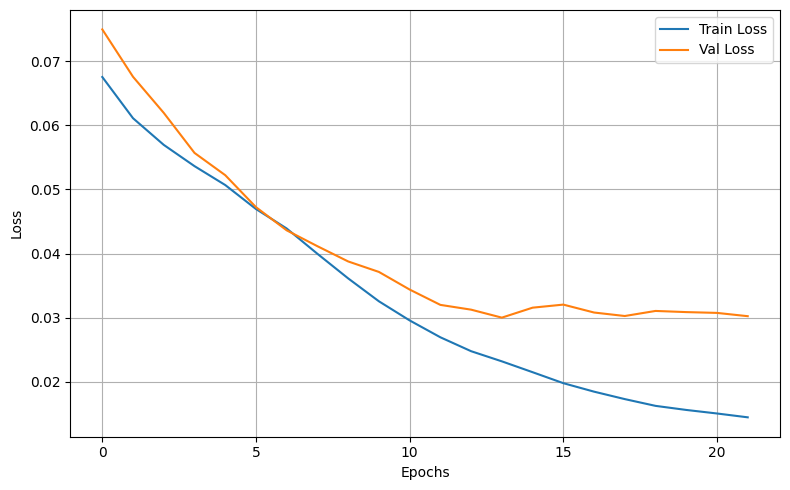

Final Training Loss: 0.0145
Final Validation Loss: 0.0303

6A. ANALYZING TRAINING & VALIDATION LOSS


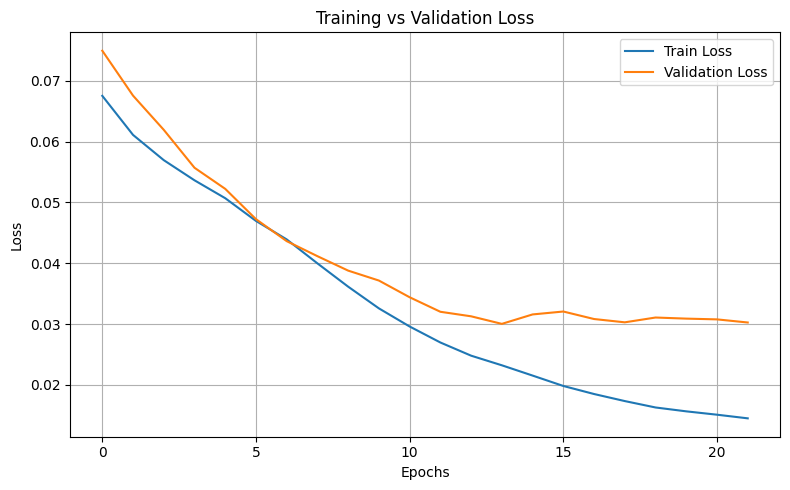

Final Training Loss: 0.0145
Final Validation Loss: 0.0303

6. EVALUATING PREDICTION METHODS


Evaluating users: 100%|██████████| 283/283 [01:13<00:00,  3.85it/s]



7. RESULTS COMPARISON
Collaborative Filtering: RMSE=0.9235, MAE=0.7595
CNN Model: RMSE=1.1357, MAE=0.9764
Hybrid Model: RMSE=0.8916, MAE=0.7396

6A. ANALYZING TRAIN & VALIDATION LOSS

6B. SAVING METHOD COMPARISON PLOTS

Results for seed 42:

Sample Train Users Metrics
       CF_RMSE    CF_MAE  CNN_RMSE   CNN_MAE  Hybrid_RMSE  Hybrid_MAE  alpha
user                                                                        
843   0.785957  0.632166  0.977984  0.817455     0.785957    0.632166   1.00
841   1.477583  1.190684  1.652329  1.516622     1.471884    1.182792   0.85
875   0.417676  0.350384  1.410220  1.324033     0.395750    0.362329   0.90
926   1.021937  0.779448  1.102344  0.963144     1.006940    0.834107   0.70
854   0.242428  0.199622  0.460978  0.397254     0.242428    0.199622   1.00

Sample Test  Users Metrics
       CF_RMSE    CF_MAE  CNN_RMSE   CNN_MAE  Hybrid_RMSE  Hybrid_MAE  alpha
user                                                                        
672   0.5

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 42, 42, 45)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 42, 42, 32)     │        12,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 42, 42, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 42, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_5             │ (None, 11, 11, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_10 (UpSampling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 22, 22, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 22, 22, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_11 (UpSampling2D) │ (None, 44, 44, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 44, 44, 1)      │           289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d_5 (Cropping2D)       │ (None, 42, 42, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,937 (343.50 KB)

 Trainable params: 87,553 (342.00 KB)

 Non-trainable params: 384 (1.50 KB)


5. TRAINING MODEL
Epoch 1/100
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0749 - masked_huber: 0.0377
Epoch 1: val_loss improved from inf to 0.07634, saving model to mdp_output/best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - loss: 0.0746 - masked_huber: 0.0374 - val_loss: 0.0763 - val_masked_huber: 0.0400 - learning_rate: 0.0010
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0631 - masked_huber: 0.0272
Epoch 2: val_loss improved from 0.07634 to 0.07071, saving model to mdp_output/best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0631 - masked_huber: 0.0272 - val_loss: 0.0707 - val_masked_huber: 0.0361 - learning_rate: 0.0010
Epoch 3/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0600 - masked_huber: 0.0259
Epoch 3: val_loss improved from 0.07071 to 0.06421, saving model to mdp_output/best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0599 - masked_huber: 0.0259 - val_loss: 0.0642 - val_masked_huber

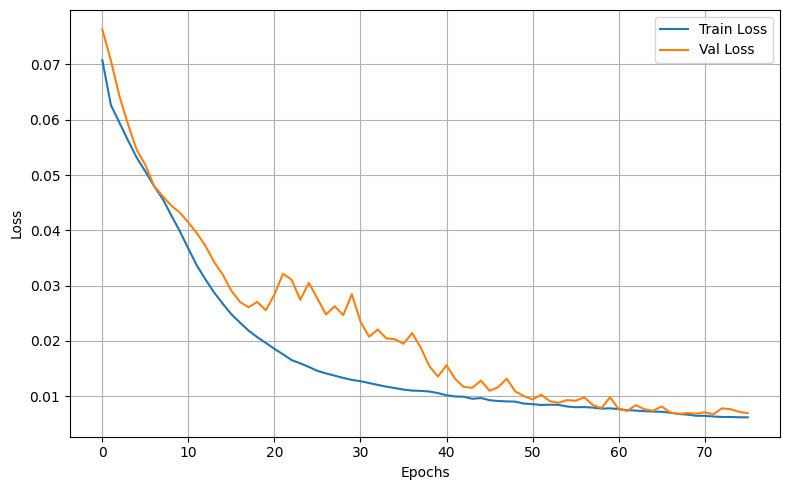

Final Training Loss: 0.0062
Final Validation Loss: 0.0069

6A. ANALYZING TRAINING & VALIDATION LOSS


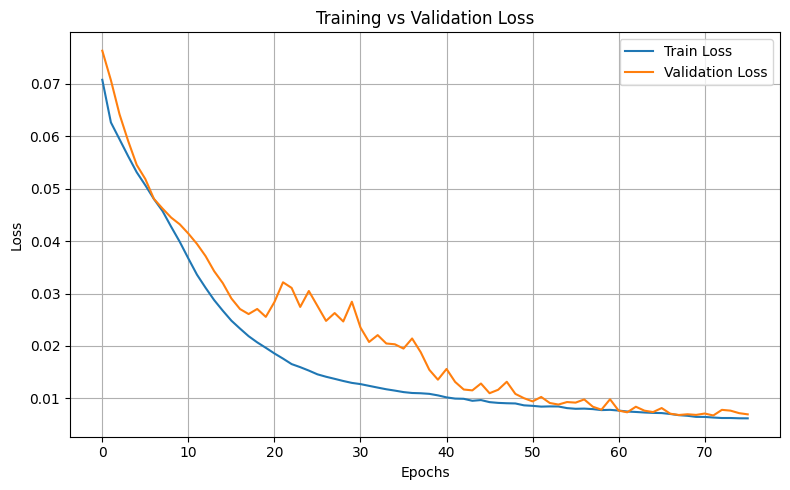

Final Training Loss: 0.0062
Final Validation Loss: 0.0069

6. EVALUATING PREDICTION METHODS


Evaluating users: 100%|██████████| 283/283 [01:14<00:00,  3.78it/s]



7. RESULTS COMPARISON
Collaborative Filtering: RMSE=0.9335, MAE=0.7744
CNN Model: RMSE=1.1541, MAE=0.9702
Hybrid Model: RMSE=0.8924, MAE=0.7444

6A. ANALYZING TRAIN & VALIDATION LOSS

6B. SAVING METHOD COMPARISON PLOTS

Results for seed 123:

Sample Train Users Metrics
       CF_RMSE    CF_MAE  CNN_RMSE   CNN_MAE  Hybrid_RMSE  Hybrid_MAE  alpha
user                                                                        
699   0.625773  0.554690  0.804464  0.753934     0.561680    0.493569    0.7
847   0.798432  0.588755  1.258475  1.048446     0.798432    0.588755    1.0
38    0.676283  0.650363  0.880724  0.650449     0.606748    0.580323    0.7
112   0.804446  0.722015  0.786207  0.641305     0.666498    0.610607    0.5
193   0.685884  0.572135  0.844472  0.667924     0.685884    0.572135    1.0

Sample Test  Users Metrics
       CF_RMSE    CF_MAE  CNN_RMSE   CNN_MAE  Hybrid_RMSE  Hybrid_MAE  alpha
user                                                                        
887   0.

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 42, 42, 45)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 42, 42, 32)     │        12,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 42, 42, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 42, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_6             │ (None, 11, 11, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_12 (UpSampling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 22, 22, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 22, 22, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_13 (UpSampling2D) │ (None, 44, 44, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 44, 44, 1)      │           289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d_6 (Cropping2D)       │ (None, 42, 42, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,937 (343.50 KB)

 Trainable params: 87,553 (342.00 KB)

 Non-trainable params: 384 (1.50 KB)


5. TRAINING MODEL
Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1095 - masked_huber: 0.0719
Epoch 1: val_loss improved from inf to 0.07609, saving model to mdp_output/best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.1085 - masked_huber: 0.0709 - val_loss: 0.0761 - val_masked_huber: 0.0388 - learning_rate: 0.0010
Epoch 2/100
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0647 - masked_huber: 0.0277
Epoch 2: val_loss improved from 0.07609 to 0.06958, saving model to mdp_output/best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0646 - masked_huber: 0.0277 - val_loss: 0.0696 - val_masked_huber: 0.0335 - learning_rate: 0.0010
Epoch 3/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0607 - masked_huber: 0.0250
Epoch 3: val_loss improved from 0.06958 to 0.06759, saving model to mdp_output/best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0607 - masked_huber: 0.0251 - val_loss: 0.0676 - val_masked_huber

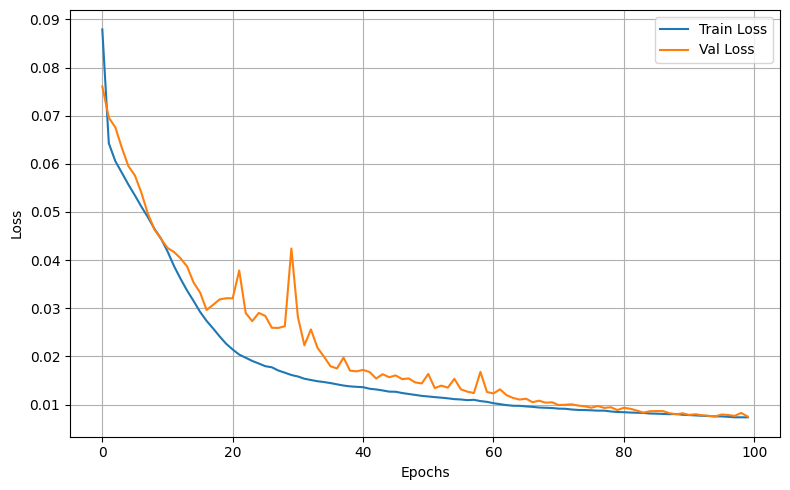

Final Training Loss: 0.0073
Final Validation Loss: 0.0075

6A. ANALYZING TRAINING & VALIDATION LOSS


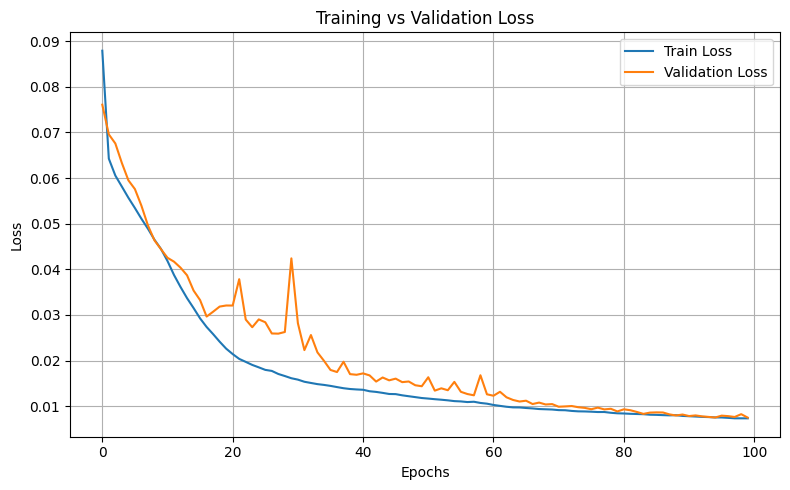

Final Training Loss: 0.0073
Final Validation Loss: 0.0075

6. EVALUATING PREDICTION METHODS


Evaluating users: 100%|██████████| 283/283 [01:17<00:00,  3.67it/s]



7. RESULTS COMPARISON
Collaborative Filtering: RMSE=0.8937, MAE=0.7304
CNN Model: RMSE=1.1312, MAE=0.9491
Hybrid Model: RMSE=0.8625, MAE=0.7124

6A. ANALYZING TRAIN & VALIDATION LOSS

6B. SAVING METHOD COMPARISON PLOTS

Results for seed 2024:

Sample Train Users Metrics
       CF_RMSE    CF_MAE  CNN_RMSE   CNN_MAE  Hybrid_RMSE  Hybrid_MAE  alpha
user                                                                        
619   1.002924  0.792832  1.246637  1.087417     1.002924    0.792832    1.0
922   0.497056  0.386143  0.733953  0.604545     0.494161    0.382596    0.9
277   0.420312  0.331360  1.326610  1.107744     0.420312    0.331360    1.0
865   0.895458  0.848931  1.141870  1.029870     0.891583    0.867025    0.9
241   0.837448  0.619036  1.451635  1.385780     0.822024    0.634481    0.9

Sample Test  Users Metrics
       CF_RMSE    CF_MAE  CNN_RMSE   CNN_MAE  Hybrid_RMSE  Hybrid_MAE  alpha
user                                                                        
940   0

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 42, 42, 45)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 42, 42, 32)     │        12,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 42, 42, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 42, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_7             │ (None, 11, 11, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_14 (UpSampling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 22, 22, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 22, 22, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_15 (UpSampling2D) │ (None, 44, 44, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 44, 44, 1)      │           289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d_7 (Cropping2D)       │ (None, 42, 42, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,937 (343.50 KB)

 Trainable params: 87,553 (342.00 KB)

 Non-trainable params: 384 (1.50 KB)


5. TRAINING MODEL
Epoch 1/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0817 - masked_huber: 0.0443
Epoch 1: val_loss improved from inf to 0.07577, saving model to mdp_output/best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.0804 - masked_huber: 0.0430 - val_loss: 0.0758 - val_masked_huber: 0.0392 - learning_rate: 0.0010
Epoch 2/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0636 - masked_huber: 0.0275
Epoch 2: val_loss improved from 0.07577 to 0.06944, saving model to mdp_output/best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0635 - masked_huber: 0.0274 - val_loss: 0.0694 - val_masked_huber: 0.0348 - learning_rate: 0.0010
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0596 - masked_huber: 0.0256
Epoch 3: val_loss improved from 0.06944 to 0.06158, saving model to mdp_output/best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0595 - masked_huber: 0.0255 - val_loss: 0.0616 - val_masked_huber

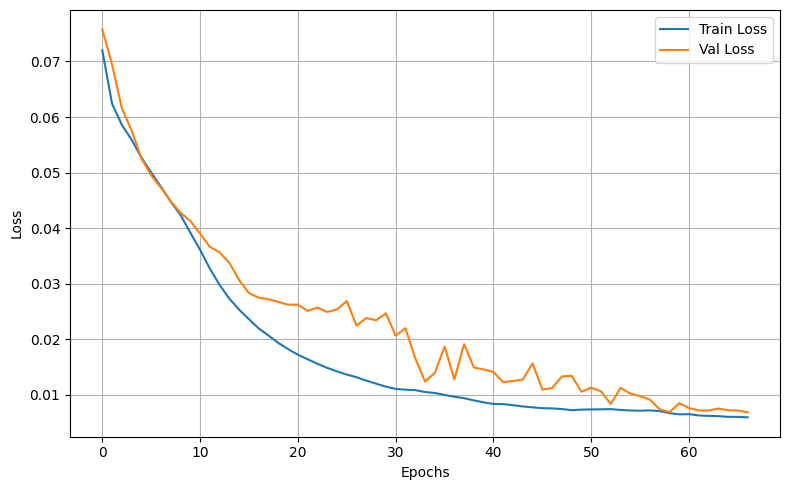

Final Training Loss: 0.0060
Final Validation Loss: 0.0069

6A. ANALYZING TRAINING & VALIDATION LOSS


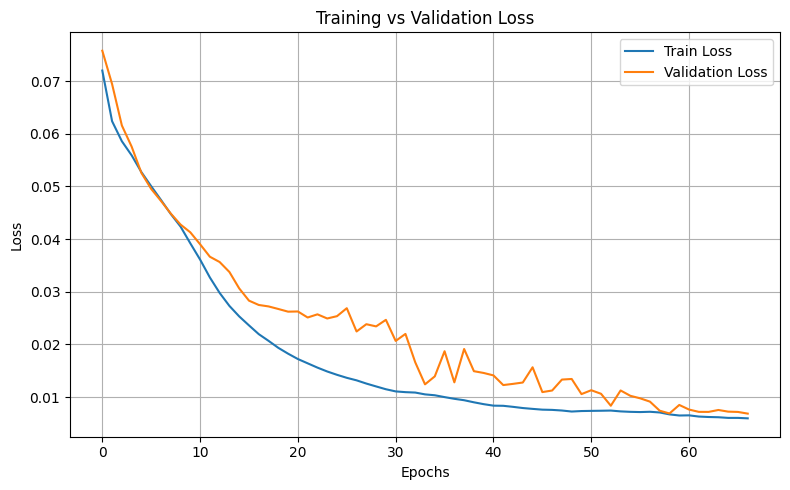

Final Training Loss: 0.0060
Final Validation Loss: 0.0069

6. EVALUATING PREDICTION METHODS


Evaluating users: 100%|██████████| 283/283 [01:16<00:00,  3.68it/s]



7. RESULTS COMPARISON
Collaborative Filtering: RMSE=0.9314, MAE=0.7621
CNN Model: RMSE=1.1414, MAE=0.9636
Hybrid Model: RMSE=0.8871, MAE=0.7357

6A. ANALYZING TRAIN & VALIDATION LOSS

6B. SAVING METHOD COMPARISON PLOTS

Results for seed 7:

Sample Train Users Metrics
       CF_RMSE    CF_MAE  CNN_RMSE   CNN_MAE  Hybrid_RMSE  Hybrid_MAE  alpha
user                                                                        
98    1.066068  0.799479  1.246977  0.981580     1.066068    0.799479   1.00
612   0.432638  0.279039  1.716564  1.668493     0.429196    0.328197   0.95
712   0.523594  0.340303  0.530935  0.383372     0.320645    0.281385   0.50
553   0.548018  0.415509  0.642117  0.543534     0.539720    0.423519   0.80
886   1.321230  1.066867  1.635612  1.419680     1.321230    1.066867   1.00

Sample Test  Users Metrics
       CF_RMSE    CF_MAE  CNN_RMSE   CNN_MAE  Hybrid_RMSE  Hybrid_MAE  alpha
user                                                                        
853   0.67

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 42, 42, 45)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 42, 42, 32)     │        12,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 42, 42, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 42, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_8             │ (None, 11, 11, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_16 (UpSampling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 22, 22, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 22, 22, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_17 (UpSampling2D) │ (None, 44, 44, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 44, 44, 1)      │           289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d_8 (Cropping2D)       │ (None, 42, 42, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,937 (343.50 KB)

 Trainable params: 87,553 (342.00 KB)

 Non-trainable params: 384 (1.50 KB)


5. TRAINING MODEL
Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0796 - masked_huber: 0.0423
Epoch 1: val_loss improved from inf to 0.07502, saving model to mdp_output/best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - loss: 0.0792 - masked_huber: 0.0419 - val_loss: 0.0750 - val_masked_huber: 0.0386 - learning_rate: 0.0010
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0627 - masked_huber: 0.0267
Epoch 2: val_loss improved from 0.07502 to 0.06932, saving model to mdp_output/best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0627 - masked_huber: 0.0268 - val_loss: 0.0693 - val_masked_huber: 0.0348 - learning_rate: 0.0010
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0581 - masked_huber: 0.0242
Epoch 3: val_loss improved from 0.06932 to 0.06161, saving model to mdp_output/best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0581 - masked_huber: 0.0242 - val_loss: 0.0616 - val_masked_huber

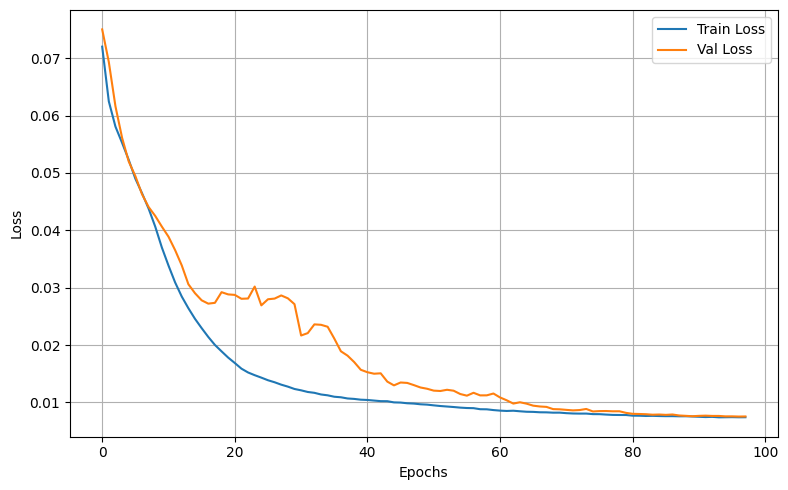

Final Training Loss: 0.0074
Final Validation Loss: 0.0075

6A. ANALYZING TRAINING & VALIDATION LOSS


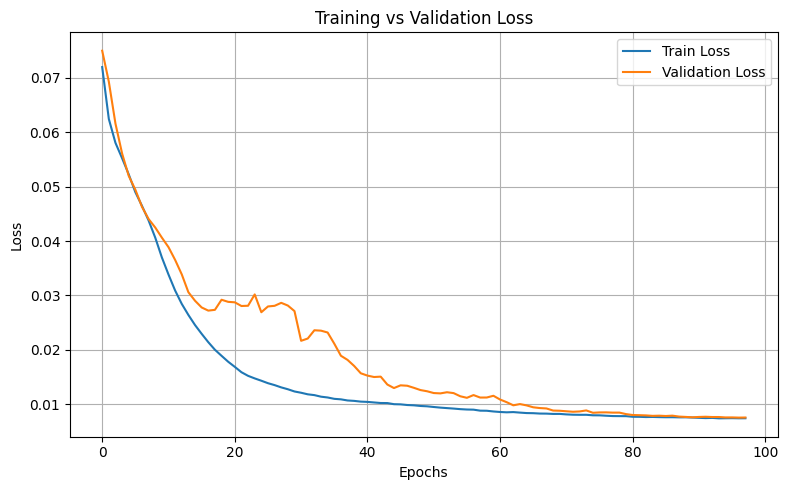

Final Training Loss: 0.0074
Final Validation Loss: 0.0075

6. EVALUATING PREDICTION METHODS


Evaluating users: 100%|██████████| 283/283 [01:16<00:00,  3.70it/s]



7. RESULTS COMPARISON
Collaborative Filtering: RMSE=0.9238, MAE=0.7589
CNN Model: RMSE=1.1110, MAE=0.9286
Hybrid Model: RMSE=0.8825, MAE=0.7297

6A. ANALYZING TRAIN & VALIDATION LOSS

6B. SAVING METHOD COMPARISON PLOTS

Results for seed 99:

Sample Train Users Metrics
       CF_RMSE    CF_MAE  CNN_RMSE   CNN_MAE  Hybrid_RMSE  Hybrid_MAE  alpha
user                                                                        
504   1.221827  1.011390  1.199331  0.885575     1.184663    0.920369   0.40
500   0.737871  0.567784  0.729540  0.612596     0.663475    0.573350   0.50
836   1.129923  0.919804  1.419376  1.195993     1.129923    0.919804   1.00
50    0.565982  0.377008  0.552324  0.481173     0.430481    0.420080   0.50
665   0.638844  0.495325  0.815304  0.642070     0.638601    0.491675   0.95

Sample Test  Users Metrics
       CF_RMSE    CF_MAE  CNN_RMSE   CNN_MAE  Hybrid_RMSE  Hybrid_MAE  alpha
user                                                                        
568   0.9

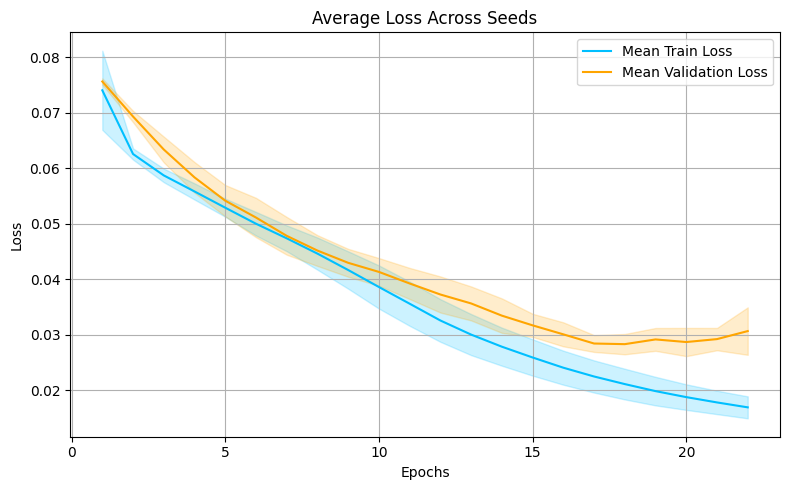

In [ ]:
  def main(
    data_path,
    user_feature_path=None,
    item_feature_path=None,
    output_dir='output',
    alpha=0.5
):
    """Main pipeline runner with feature engineering and hybrid recommendation."""
    import os
    import matplotlib.pyplot as plt

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # 1. Load and preprocess ratings
    print("\n1. LOADING AND PREPROCESSING DATA")
    ratings_df = load_ratings_data(data_path)                                    # dtype enforced, missing values handled2
    rating_matrix, mask_matrix, user_map, item_map = create_rating_matrix(ratings_df)
    mu, b_u, b_i = compute_bias_terms(rating_matrix, mask_matrix)

    # 1A. Load and encode features if provided
    user_feats, item_feats = None, None
    if user_feature_path:
        user_feats, _ = load_user_features(user_feature_path, user_map)           # safe reindex with imputation[4]
    if item_feature_path:
        item_feats, _ = load_item_features(item_feature_path, item_map)           # zero‐filled missing genres[5]

    # 2. Split users into train/test sets with masks
    print("\n2. SPLITTING DATA BY USERS")
    train_indices, test_indices, train_user_mask, test_user_mask = split_users_train_test(
        rating_matrix, train_ratio=0.7, random_state=42                            # user‐level boolean masks[6]
    )

    # 3. Prepare data as CNN inputs using NaN‐mask and reflective padding
    print("\n3. PREPARING DATA AS IMAGES")
    train_images, max_rating, mean_rating = prepare_matrix_as_image_with_features(
        rating_matrix[train_indices],
        train_mask_matrix=mask_matrix[train_indices],
        user_features_norm=(user_feats[train_indices] if user_feats is not None else None),
        item_features_norm=item_feats
    )                                                                             # fixed normalization & padding[7]
    test_images, _, _ = prepare_matrix_as_image_with_features(
        rating_matrix[test_indices],
        train_mask_matrix=mask_matrix[test_indices],
        user_features_norm=(user_feats[test_indices] if user_feats is not None else None),
        item_features_norm=item_feats
    )

    # 4. Create and compile CNN autoencoder with masked Huber loss
    print("\n4. CREATING AND COMPILING MODEL")
    input_shape = train_images.shape[1:]
    model = create_cnn_autoencoder(
        input_shape=input_shape,
        filters=32,
        kernel_size=3,
        dropout_rate=0.3,
        lr_factor=1e-4,
        use_bn=True                                                          # batch norm & L2 reg[8]
    )
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss=create_masked_loss(delta=1.0)                                   # robust Huber loss[9]
    )
    model.summary()

    # 5. Train the model with callbacks
    print("\n5. TRAINING MODEL")
    callbacks = setup_callbacks(
        patience=10,
        min_delta=1e-4,
        model_path=f"{output_dir}/best_model.weights.h5",
        tb_log_dir=f"{output_dir}/logs"
    )                                                                        # early stop + checkpoint + TensorBoard[10]
    history = train_model(
        model=model,
        train_data=train_images,
        val_data=test_images,
        batch_size=32,
        epochs=100,
        lr=1e-3,
        callbacks=callbacks
    )                                                                        # uses masked Huber, monitors val_loss[11]

    # Plot loss curves
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()                                           # visualizes training dynamics[12]
    print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
    print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")


    # === LOSS CURVE ANALYSIS ===
    print("\n6A. ANALYZING TRAINING & VALIDATION LOSS")
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
    print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

    # 6. Evaluate and compare prediction methods
    print("\n6. EVALUATING PREDICTION METHODS")

    all_cf_metrics, all_cnn_metrics, all_hybrid_metrics = [], [], []

    for user_idx in tqdm(test_indices, desc="Evaluating users"):
        true_ratings = rating_matrix[user_idx]
        obs_mask = ~np.isnan(true_ratings)                                       # NaN-based mask[1]

        # 80/20 split of observed for prediction vs evaluation
        obs_idx = np.where(obs_mask)[0]
        np.random.shuffle(obs_idx)
        split = int(0.8 * len(obs_idx))
        pred_idx, eval_idx = obs_idx[:split], obs_idx[split:]

        # --- NEW: Split pred_idx into CF-tuning and CF-training ---
        if len(pred_idx) > 10:
            np.random.shuffle(pred_idx)
            cf_tune_split = int(0.8 * len(pred_idx))
            cf_train_idx, cf_val_idx = pred_idx[:cf_tune_split], pred_idx[cf_tune_split:]
        else:
            cf_train_idx, cf_val_idx = pred_idx, np.array([], dtype=int)

        # Build train mask for CF (hide eval and cf_val entries)
        user_train_mask = mask_matrix.copy()
        user_train_mask[user_idx, :] = False
        user_train_mask[user_idx, cf_train_idx] = True

        # --- Collaborative Filtering with hyperparameter tuning on cf_val_idx ---
        best_rmse, best_k, best_ov = np.inf, 30, 5
        for ov in [5, 10, 15]:
            for k in [10, 20, 30, 40, 50]:
                neigh, sims = find_similar_users(
                    rating_matrix, user_train_mask, train_indices, user_idx,
                    mu, b_u, b_i, top_n=k, base_overlap=ov, lambda_shrink=10.0
                )
                if not neigh:
                    continue
                cf_temp = (
                    enhanced_fallback_prediction(
                        rating_matrix, mask_matrix, mu, b_u, b_i, user_idx
                    ) if len(neigh) < 5 else
                    predict_ratings_cf(
                        rating_matrix, user_train_mask, neigh, sims,
                        user_idx, mu, b_u, b_i, lambda_shrink=10.0
                    )
                )
                # --- Evaluate on cf_val_idx, NOT eval_idx ---
                if len(cf_val_idx) > 0:
                    rm = np.sqrt(np.mean((true_ratings[cf_val_idx] - cf_temp[cf_val_idx])**2))
                    if rm < best_rmse:
                        best_rmse, best_k, best_ov = rm, k, ov
                else:
                    # Not enough data for validation: skip tuning
                    pass

        # After tuning, rebuild user_train_mask to include all pred_idx for final CF
        user_train_mask[user_idx, :] = False
        user_train_mask[user_idx, pred_idx] = True

        # Final CF predictions (evaluate on eval_idx)
        neigh, sims = find_similar_users(
            rating_matrix, user_train_mask, train_indices, user_idx,
            mu, b_u, b_i, top_n=best_k, base_overlap=best_ov, lambda_shrink=10.0
        )
        cf_pred = (
            enhanced_fallback_prediction(rating_matrix, mask_matrix, mu, b_u, b_i, user_idx)
            if len(neigh) < 5 else
            predict_ratings_cf(
                rating_matrix, user_train_mask, neigh, sims,
                user_idx, mu, b_u, b_i, lambda_shrink=10.0
            )
        )


        # Final CF predictions
        neigh, sims = find_similar_users(
            rating_matrix, user_train_mask, train_indices, user_idx,
            mu, b_u, b_i, top_n=best_k, base_overlap=best_ov, lambda_shrink=10.0
        )
        cf_pred = (
            enhanced_fallback_prediction(rating_matrix, mask_matrix, mu, b_u, b_i, user_idx)
            if len(neigh) < 5 else
            predict_ratings_cf(
                rating_matrix, user_train_mask, neigh, sims,
                user_idx, mu, b_u, b_i, lambda_shrink=10.0
            )
        )

        # --- CNN Prediction with eval_idx hidden ---
        masked_ratings = true_ratings.copy()
        masked_ratings[eval_idx] = np.nan  # Hide eval_idx ratings from CNN input
        h, w = train_images.shape[1:3]
        user_img = prepare_single_user_data_with_features(
            masked_ratings, max_rating, mean_rating,
            n_items=rating_matrix.shape[1], height=h, width=w,
            user_feat_norm=(user_feats[user_idx] if user_feats is not None else None),
            item_feats_norm=item_feats
        )
        cnn_raw = model.predict(user_img, verbose=0)[0, :, :, 0].ravel()[:len(true_ratings)]
        cnn_pred = cnn_raw * max_rating


        # --- Hybrid Combination with per-user alpha tuning ---
        alphas = np.arange(0, 1.05, 0.05)
        best_hybrid, best_alpha = None, 0.5
        best_rmse_h = np.inf
        for a in alphas:
            hybrid_temp = a * cf_pred + (1 - a) * cnn_pred
            rm_h = np.sqrt(np.mean((true_ratings[eval_idx] - hybrid_temp[eval_idx])**2))
            if rm_h < best_rmse_h:
                best_rmse_h, best_alpha, best_hybrid = rm_h, a, hybrid_temp

        # Evaluate all methods
        cf_metrics     = evaluate_predictions(true_ratings, cf_pred, eval_mask=eval_idx)
        cnn_metrics    = evaluate_predictions(true_ratings, cnn_pred, eval_mask=eval_idx)
        hybrid_metrics = evaluate_predictions(true_ratings, best_hybrid, eval_mask=eval_idx)

        all_cf_metrics.append(cf_metrics)
        all_cnn_metrics.append(cnn_metrics)
        all_hybrid_metrics.append(hybrid_metrics)

    # Compute average metrics
    avg = lambda lst, m: np.mean([x[m] for x in lst])
    avg_cf = {'RMSE': avg(all_cf_metrics, 'RMSE'), 'MAE': avg(all_cf_metrics, 'MAE')}
    avg_cnn= {'RMSE': avg(all_cnn_metrics,'RMSE'), 'MAE': avg(all_cnn_metrics,'MAE')}
    avg_hyb= {'RMSE': avg(all_hybrid_metrics,'RMSE'),'MAE': avg(all_hybrid_metrics,'MAE')}

    print("\n7. RESULTS COMPARISON")
    print(f"Collaborative Filtering: RMSE={avg_cf['RMSE']:.4f}, MAE={avg_cf['MAE']:.4f}")
    print(f"CNN Model: RMSE={avg_cnn['RMSE']:.4f}, MAE={avg_cnn['MAE']:.4f}")
    print(f"Hybrid Model: RMSE={avg_hyb['RMSE']:.4f}, MAE={avg_hyb['MAE']:.4f}")


    # === LOSS CURVE ANALYSIS ===
    print("\n6A. ANALYZING TRAIN & VALIDATION LOSS")
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')  # masked Huber loss[1]
    plt.plot(history.history['val_loss'], label='Val Loss')  # masked Huber loss[1]
    plt.title('Model Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_history.png'))
    plt.close()

    # === PREDICTION METHOD COMPARISON ===
    print("\n6B. SAVING METHOD COMPARISON PLOTS")
    methods = ['Collaborative Filtering', 'CNN', 'Hybrid']
    rmse_vals = [avg_cf['RMSE'], avg_cnn['RMSE'], avg_hyb['RMSE']]
    mae_vals  = [avg_cf['MAE'],  avg_cnn['MAE'],  avg_hyb['MAE']]

    x = np.arange(len(methods))
    width = 0.35

    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, rmse_vals, width, label='RMSE')       # error metrics over NaN-masked eval[2]
    plt.bar(x + width/2, mae_vals, width,  label='MAE')        # error metrics over NaN-masked eval[2]
    plt.title('Comparison of Prediction Methods')
    plt.xlabel('Method')
    plt.ylabel('Error (Lower Is Better)')
    plt.xticks(x, methods)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'method_comparison.png'))
    plt.close()

    # === RETURN RESULTS ===
    return (
        history,
        model,
        {
            'CF':     avg_cf,
            'CNN':    avg_cnn,
            'Hybrid': avg_hyb
        },
        rating_matrix,
        mask_matrix,
        test_indices,
        train_indices,
        user_feats,       # pre-normalized user features or None
        item_feats,       # pre-normalized item features or None
        max_rating,       # fixed scale used for normalization
        mean_rating,      # training-only mean for NaN imputation
        item_map,
        mu, b_u, b_i
    )

def evaluate_samples(
    train_indices,
    test_indices,
    rating_matrix,
    model,
    user_features,
    item_features,
    max_rating,
    mean_rating,
    mask_matrix,
    mu,b_u,b_i
):
    import numpy as np
    from tqdm import tqdm

    train_indices = np.array(train_indices).ravel()
    test_indices = np.array(test_indices).ravel()
    # Sample a few users from train and test sets
    sample_train = np.random.choice(train_indices, size=min(5, len(train_indices)), replace=False)  # [1]
    sample_test  = np.random.choice(test_indices,  size=min(5, len(test_indices)),  replace=False)  # [1]

    train_results, test_results = [], []

    def evaluate_user(user_idx, observed_ratio=0.8):
      """Evaluate CF, CNN, and hybrid for one user with strict NaN masking."""
      user_idx = int(user_idx)

      true_r = rating_matrix[user_idx]
      obs_mask = ~np.isnan(true_r)  # Boolean mask of observed ratings [2]

        # 80/20 split of observed ratings
      idxs = np.where(obs_mask)[0]
      np.random.shuffle(idxs)
      cut = int((1 - observed_ratio) * len(idxs))
      eval_idxs, train_idxs = idxs[:cut], idxs[cut:]

        # Build train_mask to hide eval entries
      train_mask = np.array(mask_matrix, copy=True)
      train_mask[user_idx, :]= False
      train_mask[user_idx, train_idxs] = True  # Reveal only training subset [3]

        # ---- Collaborative Filtering with shrinkage & bias ----
      best_rmse, best_k, best_ov = float('inf'), 30, 5
      for ov in [5, 10, 15]:
        for k in [10, 20, 30, 40, 50]:
          neigh, sims = find_similar_users(
                    rating_matrix,
                    train_mask,
                    train_indices,
                    user_idx,
                    mu, b_u, b_i,
                    top_n=k,
                    base_overlap=ov,
                    lambda_shrink=10.0
                )  # Bias-centered residuals with shrinkage [4]
          if not neigh:
            continue

          if len(neigh) < 5:
            cf_pred = enhanced_fallback_prediction(
                        rating_matrix, mask_matrix, mu, b_u, b_i, user_idx
                    )  # Bias-aware fallback baseline [5]
          else:
                    cf_pred = predict_ratings_cf(
                        rating_matrix, train_mask, neigh, sims,
                        user_idx, mu, b_u, b_i, lambda_shrink=10.0
                    )

          rm = np.sqrt(np.mean((true_r[eval_idxs] - cf_pred[eval_idxs])**2))
          if rm < best_rmse:
                    best_rmse, best_k, best_ov = rm, k, ov

        # Final CF predictions
      neigh, sims = find_similar_users(
            rating_matrix,
            train_mask,
            train_indices,
            user_idx,
            mu, b_u, b_i,
            top_n=best_k,
            base_overlap=best_ov,
            lambda_shrink=10.0
        )
      cf_pred = (
            enhanced_fallback_prediction(rating_matrix, mask_matrix, mu, b_u, b_i, user_idx)
            if len(neigh) < 5 else
            predict_ratings_cf(
                rating_matrix, train_mask, neigh, sims,
                user_idx, mu, b_u, b_i, lambda_shrink=10.0
            )
        )

        # ---- CNN Prediction with features ----
      h, w = model.input.shape[1:3]
      u_feat = (user_features[user_idx] if user_features is not None else None)
      i_feat = item_features
      masked_r = true_r.copy()
      masked_r[eval_idxs] = np.nan  # Hide eval_idxs from CNN input

      user_img = prepare_single_user_data_with_features(
          masked_r, max_rating, mean_rating,
          n_items=rating_matrix.shape[1], height=h, width=w,
          user_feat_norm=u_feat, item_feats_norm=i_feat
      )
      cnn_raw = model.predict(user_img, verbose=0)[0, :, :, 0].ravel()[:len(true_r)]
      cnn_pred = cnn_raw * max_rating
        # Fixed-scale rescaling [7]

        # ---- Hybrid α Tuning per user ----
      alphas, best_alpha, best_hybrid, best_rmse_h = np.arange(0,1.05,0.05), 0.5, None, float('inf')
      for a in alphas:
            hyp = a * cf_pred + (1 - a) * cnn_pred
            rm = np.sqrt(np.mean((true_r[eval_idxs] - hyp[eval_idxs])**2))
            if rm < best_rmse_h:
                best_rmse_h, best_alpha, best_hybrid = rm, a, hyp

        # Evaluate metrics using masked subset
      cf_m  = evaluate_predictions(true_r, cf_pred, eval_mask=eval_idxs)
      cnn_m = evaluate_predictions(true_r, cnn_pred, eval_mask=eval_idxs)
      hyb_m = evaluate_predictions(true_r, best_hybrid, eval_mask=eval_idxs)
      hyb_m['alpha'] = best_alpha

      return cf_m, cnn_m, hyb_m

    # Evaluate on samples
    for u in sample_train:
      cf_m, cnn_m, hyb_m = evaluate_user(u)
      train_results.append({'user': u, 'CF': cf_m, 'CNN': cnn_m, 'Hybrid': hyb_m})
    for u in sample_test:
      cf_m, cnn_m, hyb_m = evaluate_user(u)
      test_results.append({'user': u, 'CF': cf_m, 'CNN': cnn_m, 'Hybrid': hyb_m})

    return train_results, test_results



if __name__ == "__main__":
    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    # Configure paths and parameters
    data_path = os.path.join("data", "ratings.csv")
    user_feature_path = os.path.join("data", "ml-100k", "u.user")
    item_feature_path = os.path.join("data", "ml-100k", "u.item")
    output_dir = "mdp_output"
    alpha = 0.7  # Hybrid blending weight

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Seeds for reproducibility
    seeds = [42, 123, 2024, 7, 99]
    all_seed_results = []
    all_train_losses = []
    all_val_losses = []

    for seed in seeds:
        set_seed(seed)  # Set global, NumPy, and TensorFlow seeds

        # Run main pipeline
        (history, model, results,
         rating_matrix, mask_matrix, test_indices, train_indices,
         user_feats, item_feats,
         max_rating, mean_rating, item_map, mu, b_u, b_i) = main(
            data_path,
            user_feature_path=user_feature_path,
            item_feature_path=item_feature_path,
            output_dir=output_dir,
            alpha=alpha
        )

        # Collect per-seed loss curves
        all_train_losses.append(history.history['loss'])
        all_val_losses.append(history.history['val_loss'])

        # Aggregate final metrics
        all_seed_results.append({
            'seed': seed,
            'CF_RMSE': results['CF']['RMSE'],
            'CF_MAE':  results['CF']['MAE'],
            'CNN_RMSE': results['CNN']['RMSE'],
            'CNN_MAE':  results['CNN']['MAE'],
            'Hybrid_RMSE': results['Hybrid']['RMSE'],
            'Hybrid_MAE':  results['Hybrid']['MAE']
        })

        # Evaluate sample users for this seed
        train_samples, test_samples = evaluate_samples(
            train_indices, test_indices,
            rating_matrix, model,
            user_feats, item_feats,
            max_rating, mean_rating,
            mask_matrix, mu, b_u, b_i
        )
        print(f"\nResults for seed {seed}:")
        print_results_as_table(train_samples, "Sample Train Users Metrics")
        print_results_as_table(test_samples,  "Sample Test  Users Metrics")
        print("-" * 60)

    # Align loss lengths across seeds and compute statistics
    min_ep = min(len(l) for l in all_train_losses)
    train_losses = np.array([l[:min_ep] for l in all_train_losses])
    val_losses   = np.array([l[:min_ep] for l in all_val_losses])
    epochs = np.arange(1, min_ep + 1)

    mean_train = np.mean(train_losses, axis=0)
    std_train  = np.std(train_losses, axis=0)
    mean_val   = np.mean(val_losses, axis=0)
    std_val    = np.std(val_losses, axis=0)

    # Summarize seed results
    df = pd.DataFrame(all_seed_results)
    print("\nAveraged results across seeds:")
    print(df.mean(numeric_only=True))
    print("\nSeed-to-seed standard deviations:")
    print(df.std(numeric_only=True))

    # Plot mean loss curves with shading
    plt.figure(figsize=(8,5))
    plt.plot(epochs, mean_train, label='Mean Train Loss', color='deepskyblue')
    plt.fill_between(epochs, mean_train - std_train, mean_train + std_train, alpha=0.2, color='deepskyblue')
    plt.plot(epochs, mean_val, label='Mean Validation Loss', color='orange')
    plt.fill_between(epochs, mean_val - std_val, mean_val + std_val, alpha=0.2, color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Average Loss Across Seeds')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Load movie titles for final recommendation display
    movies_cols = [
        'itemId','title','release_date','video_release_date','IMDb_URL',
        'unknown','Action','Adventure','Animation',"Children's",'Comedy',
        'Crime','Documentary','Drama','Fantasy','Film-Noir','Horror',
        'Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'
    ]
    movies_df = pd.read_csv(
        os.path.join("data", "ml-100k", "u.item"),
        sep='|', names=movies_cols, encoding='latin-1'
    )
    movies_df = movies_df[['itemId','title']]  # Keep only ID and title


In [ ]:
import pandas as pd
import numpy as np

# 1. Load movie metadata with explicit dtypes
movies_cols = [
    'itemId', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
    'unknown','Action','Adventure','Animation',"Children's",'Comedy',
    'Crime','Documentary','Drama','Fantasy','Film-Noir','Horror',
    'Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'
]
movies_df = pd.read_csv(
    'data/ml-100k/u.item',
    sep='|',
    names=movies_cols,
    encoding='latin-1',
    dtype={'itemId': int, 'title': str}
)  # Ensures consistent parsing of item IDs and titles[2]
movies_df = movies_df[['itemId', 'title']]

# 2. Select the first test user for recommendations
user_idx = test_indices[0]

# 3. Build NaN-based mask for observed ratings
observed_mask = ~np.isnan(rating_matrix[user_idx])  # NaN indicates missing[1]

# 4. Prepare CNN input for this user
height, width = model.input.shape[1:3]
user_feat = user_feats[user_idx] if user_feats is not None else None
item_feats = item_feats if item_feats is not None else None
n_items = rating_matrix.shape[1]

user_data = prepare_single_user_data_with_features(
    user_vector=rating_matrix[user_idx],
    max_rating=max_rating,
    mean_rating=mean_rating,
    n_items=n_items,
    height=height,
    width=width,
    user_feat_norm=user_feat,
    item_feats_norm=item_feats
)
cnn_pred = model.predict(user_data, verbose=0)[0, :, :, 0].flatten()[:n_items] * max_rating
# CNN predictions scaled back to original rating range

# 5. Construct training mask for CF (hide all test-user ratings except observed)
train_mask = mask_matrix.copy()
train_mask[user_idx, :] = False
train_mask[user_idx, observed_mask] = True

# 6. Find similar users with bias-centering and shrinkage
similar_user_indices, similarities = find_similar_users(
    rating_matrix=rating_matrix,
    train_mask=train_mask,
    train_indices=train_indices,
    test_user_idx=user_idx,
    mu=mu,
    b_u=b_u,
    b_i=b_i,
    top_n=30,
    base_overlap=5,
    lambda_shrink=10.0
)

# 7. Handle case of insufficient neighbors
if len(similar_user_indices) < 5:
    print(f"Warning: Only {len(similar_user_indices)} neighbors for user {user_idx}")
    if len(similar_user_indices) == 0:
        cf_predictions = np.full(n_items, mu, dtype=np.float32)  # Global mean fallback
    else:
        cf_predictions = enhanced_fallback_prediction(
            rating_matrix, mask_matrix, mu, b_u, b_i, user_idx
        )
else:
    cf_predictions = predict_ratings_cf(
        rating_matrix=rating_matrix,
        train_mask=train_mask,
        similar_user_indices=similar_user_indices,
        similarities=similarities,
        test_user_idx=user_idx,
        mu=mu,
        b_u=b_u,
        b_i=b_i,
        lambda_shrink=10.0
    )

# 8. Combine CF and CNN into hybrid scores
hybrid_predictions = alpha * cf_predictions + (1 - alpha) * cnn_pred

# 9. Suppress already rated items
recommend_scores = np.where(observed_mask, -np.inf, hybrid_predictions)  # Rated items set to -∞[3]
recommended_indices = np.argsort(recommend_scores)[::-1][:10]             # Top 10 indices

# 10. Map back to MovieLens item IDs and fetch titles
inv_item_map = {v: k for k, v in item_map.items()}                    # Invert mapping
recommended_ids = [inv_item_map[idx] for idx in recommended_indices]
recommended_movies = movies_df.set_index('itemId').loc[recommended_ids].reset_index()

print("Top 10 recommendations for user", user_idx)
print(recommended_movies[['itemId', 'title']])


Top 10 recommendations for user 96
   itemId                                              title
0     178                                12 Angry Men (1957)
1     114  Wallace & Gromit: The Best of Aardman Animatio...
2     483                                  Casablanca (1942)
3      64                   Shawshank Redemption, The (1994)
4     654                                   Chinatown (1974)
5     170                             Cinema Paradiso (1988)
6     272                           Good Will Hunting (1997)
7     180                              Apocalypse Now (1979)
8     190                                     Henry V (1989)
9     318                            Schindler's List (1993)
